In [35]:
import spreg
from spreg import OLS
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
selected = gpd.read_file('../raw_data/selected_gdf.shp')

In [38]:
selected.B_age.value_counts()

B_1940         265
B_1941_1990    211
B_1991_2015     60
Name: B_age, dtype: int64

In [64]:
selected = pd.concat([selected, transformed_b_age], ignore_index=False, sort=False, axis=1)

In [2]:
gdf = gpd.read_file("../raw_data/data_dropped/data_dropped.shp")

In [ ]:
final = gpd.read_file("../school-map-project/data/final_gdf.shp")

In [3]:
gdf.drop(columns=[
    'ant_arbeit', 'ant_transf', 'ant_arbe_1', 'ant_tran_1', 'Kinderar_1',
    'PLR_ID', 'MH_E','aenderung_'
],
        inplace=True)

In [4]:
queen = libpysal.weights.Queen.from_dataframe(selected)

In [3]:
rook = libpysal.weights.Rook.from_dataframe(selected)

In [4]:
selected.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   public_tra  536 non-null    int64   
 1   eating      536 non-null    float64 
 2   culture     536 non-null    float64 
 3   community   536 non-null    float64 
 4   health_car  536 non-null    float64 
 5   public_ser  536 non-null    int64   
 6   education   536 non-null    float64 
 7   schools     536 non-null    float64 
 8   universiti  536 non-null    float64 
 9   kindergart  536 non-null    float64 
 10  outdoor_fa  536 non-null    float64 
 11  outdoor_le  536 non-null    float64 
 12  night_life  536 non-null    float64 
 13  water       536 non-null    float64 
 14  ave_rent    536 non-null    float64 
 15  social_hou  536 non-null    float64 
 16  public_hou  536 non-null    float64 
 17  dyn_ew      536 non-null    float64 
 18  five_y_pls  536 non-null    float64 
 19  

In [90]:
y = np.array(selected['child_pov'])
X = selected.drop(columns=[
    'child_pov', 'geometry', 'B_age', 'water', 'universiti',
    'health_car', 'culture', 'public_ser'
]).to_numpy()

In [29]:
columns = [
    'public_tra', 'eating',  'community',
    'education', 'schools', 'kindergart', 'outdoor_fa',
    'outdoor_le', 'night_life', 'ave_rent', 'social_hou',
    'public_hou', 'dyn_ew', 'dyn_sales', 'dyn_unempl', 'noise',
    'air', 'green', 'bio', 'mig_rate'
]

In [30]:
len(columns)

20

In [31]:
X.shape

(536, 20)

In [32]:
basic_ols = OLS(y,
                X,
                w=rook,
                name_y='child_pov',
                name_x=columns,
                name_w='Rook',
                name_ds='basic_model',
                white_test=True,
                gwk=rook,
                spat_diag=True,
                moran=True,)

In [33]:
basic_ols.white

'Not computed due to multicollinearity.'

In [34]:
print(basic_ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            : basic_model
Weights matrix      :        Rook
Dependent Variable  :   child_pov                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          21
S.D. dependent var  :     16.6701                Degrees of Freedom    :         515
R-squared           :      0.7808
Adjusted R-squared  :      0.7723
Sum squared residual:   32591.949                F-statistic           :     91.7124
Sigma-square        :      63.285                Prob(F-statistic)     :  3.353e-155
S.E. of regression  :       7.955                Log likelihood        :   -1861.411
Sigma-square ML     :      60.806                Akaike info criterion :    3764.822
S.E of regression ML:      7.7978                Schwarz criterion     :    3854.789

-----------------------------------------------------------------------------

In [72]:
clusters = ['night_life', 'ave_rent', 'social_hou','public_hou', 'child_pov', 'mig_rate', 'dyn_sales', 'noise']

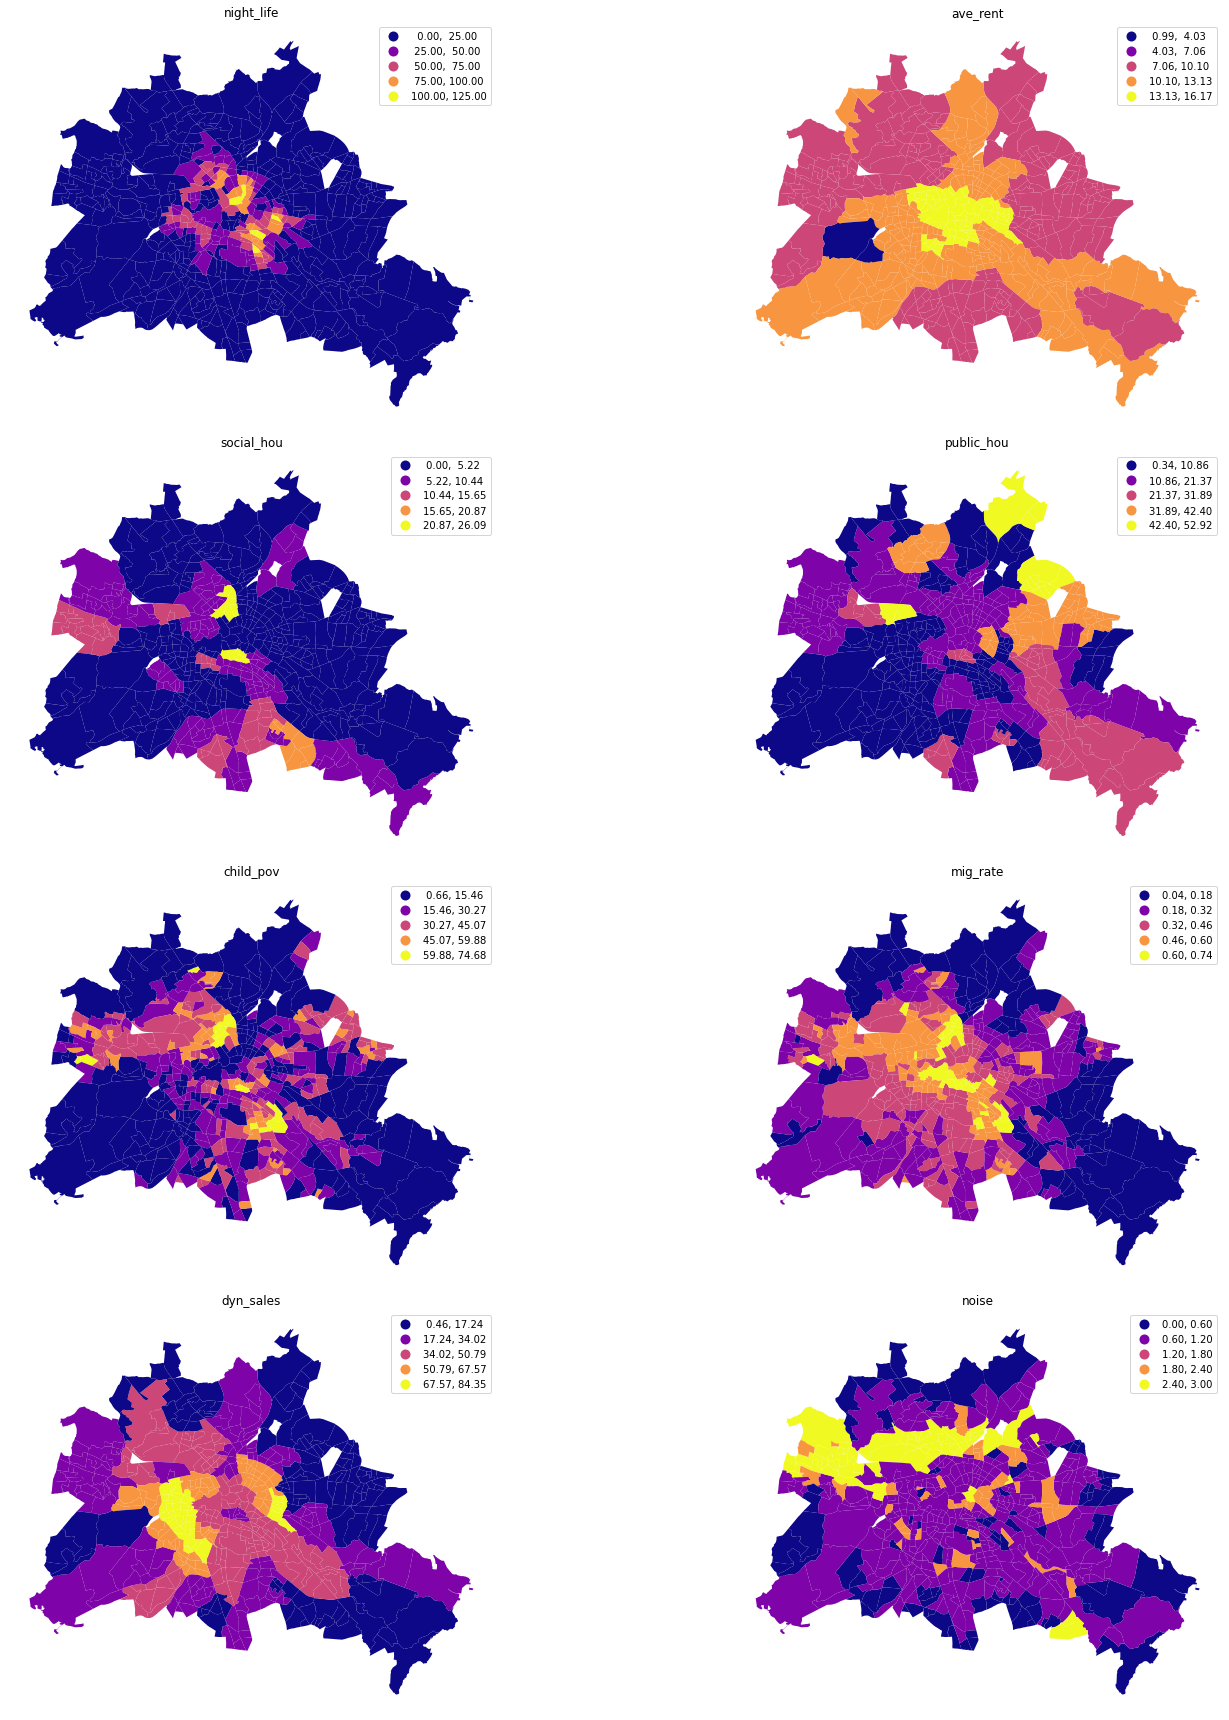

In [89]:
f, axs = plt.subplots(nrows=4, ncols=2, figsize=(24, 24))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(iterable=clusters):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    selected.plot(
        column=col,
        ax=ax,
        scheme="EqualInterval",
        linewidth=0,
        cmap="plasma",
        legend=True
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
f.tight_layout()
plt.show()

In [55]:
queen = libpysal.weights.Queen.from_dataframe(selected)

In [64]:
from esda.moran import Moran

In [70]:
import seaborn

In [73]:
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [
    Moran(selected[variable], queen) for variable in clusters
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(clusters, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

,Moran's I,P-value
Variable,,
night_life,0.817334,0.001
ave_rent,0.808404,0.001
social_hou,0.610209,0.001
public_hou,0.746134,0.001
child_pov,0.519632,0.001
mig_rate,0.733919,0.001
dyn_sales,0.832748,0.001
noise,0.564080,0.001


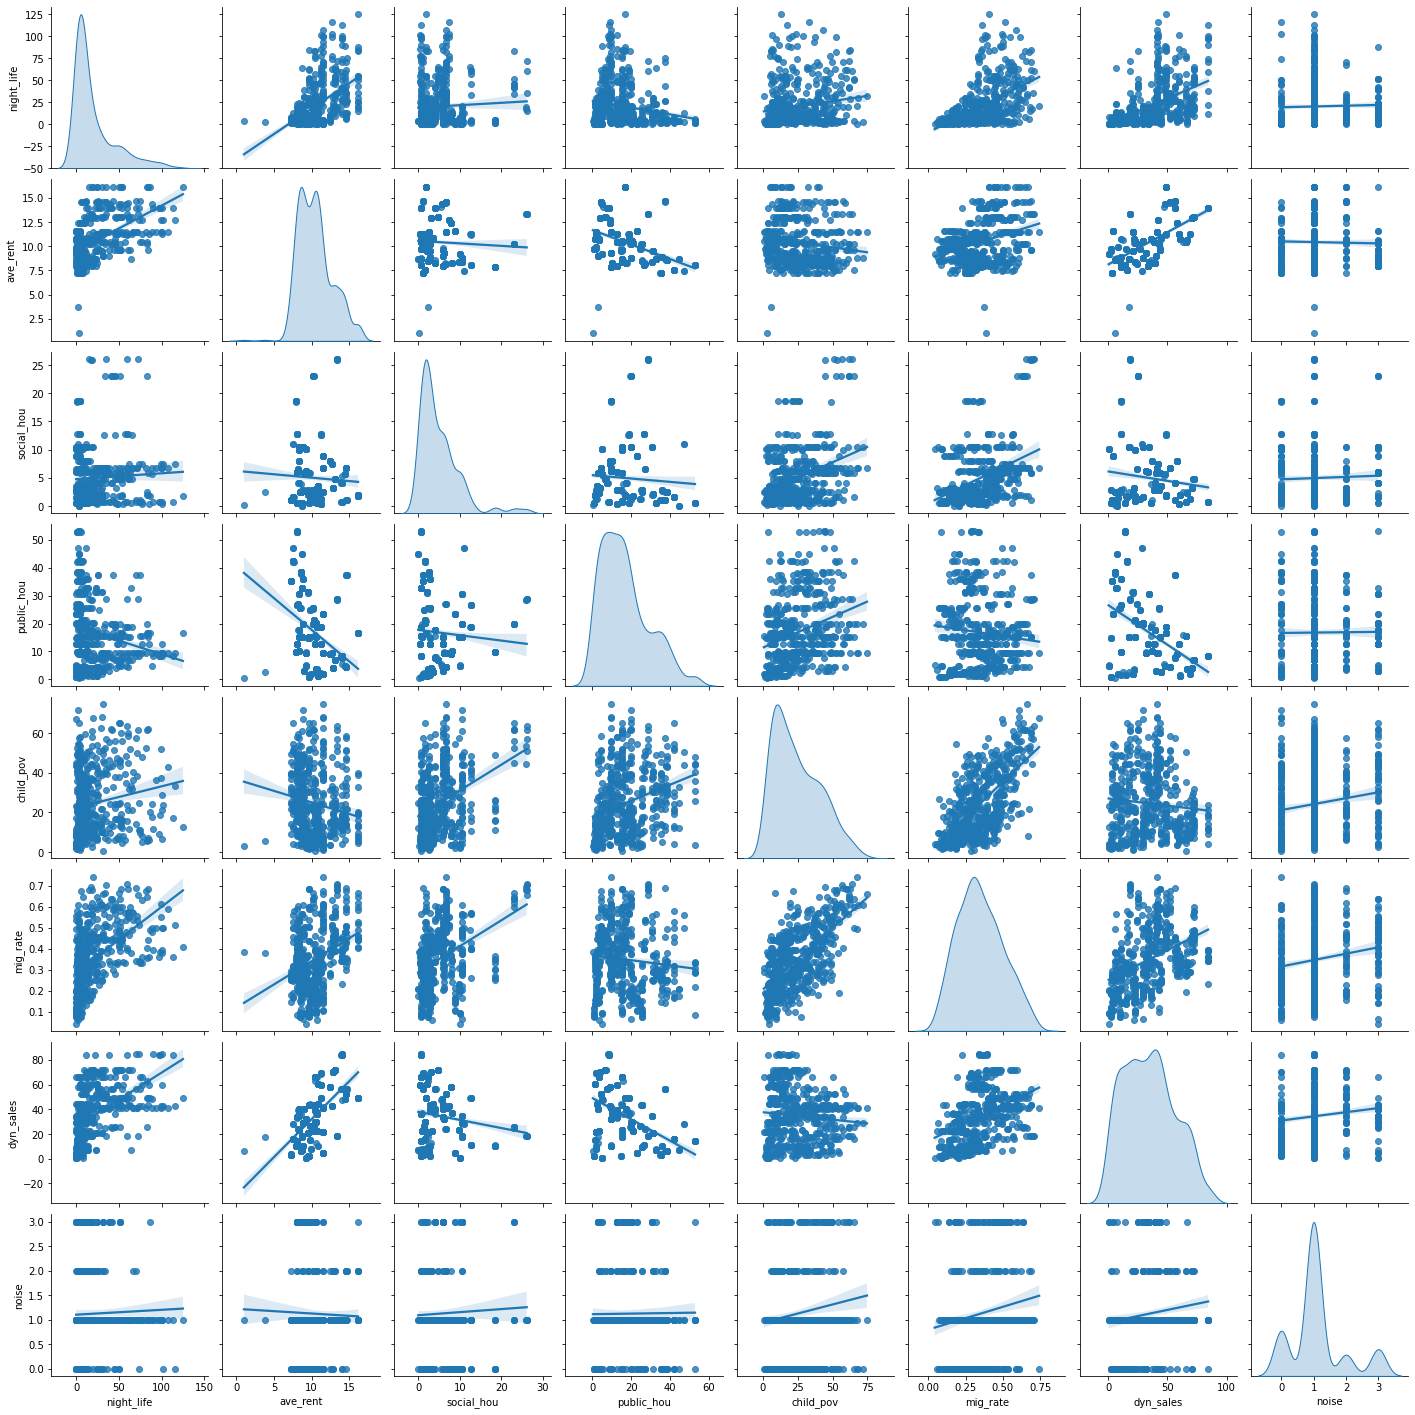

In [74]:
_ = seaborn.pairplot(
    selected[clusters], kind="reg", diag_kind="kde"
)

In [75]:
from sklearn.preprocessing import robust_scale

In [76]:
db_scaled = robust_scale(selected[clusters])

In [84]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db_scaled)
k5cls.labels_[:4]

array([0, 1, 3, 1], dtype=int32)

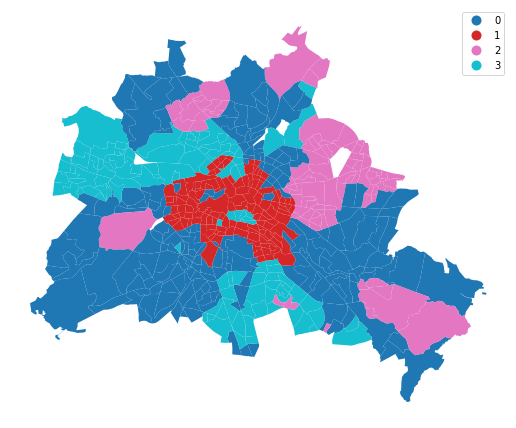

In [85]:
# Assign labels into a column
selected["k5cls"] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
selected.plot(
    column="k5cls", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [87]:
# Group data table by cluster label and count observations
k5sizes = selected.groupby("k5cls").size()
k5sizes

k5cls
0    198
1    130
2     94
3    114
dtype: int64